<a href="https://colab.research.google.com/github/Braafisch/ASD-Assignments/blob/main/asd_assignment7/asd_assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vorlesung ASD, HS Esslingen, Thao Dang

# A* Algorithmus

In dieser Übung werden Sie den A* Algorithmus aus der Vorlesung nachimplementieren. Sie suchen einen optimalen Pfad für einen Roboter, der sich in einem unbekannten Terrain holonom fortbewegen kann.

## Vorbereitungen

In [2]:
import matplotlib.pyplot as plt
import math
import numpy as np
import sys

Das Labyrinth, in dem sich der Roboter bewegen soll, ist durch ein 2D-Gitter gegeben. Eine Gitterzelle mit Wert 0 ist dabei frei, eine Gitterzelle mit Wert 1 als belegt zu betrachten. Ausserdem sind sowohl die Start- als auch die Zielposition des Roboters bekannt:

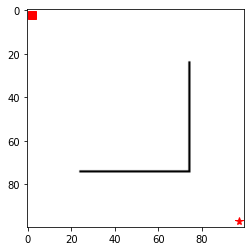

In [3]:
maze = np.zeros((100, 100))
maze[24:75, 74] = np.ones(maze[24:75, 74].shape)
maze[74, 24:75] = np.ones(maze[74, 24:75].shape)

N, M = maze.shape

plt.imshow(1-maze.T, cmap='gray')

# define start and goal position
startx, starty = 2, 2
goalx, goaly = N-3, M-3

plt.plot(startx, starty, 'rs', Markersize=8, LineWidth=2)
plt.plot(goalx, goaly, 'r*', Markersize=8, LineWidth=2);

Um die offenen und geschlossenen Listen einfacher zu verwalten, ist es sinnvoll, jede Gitterposition durch einen 1D-Index (anstatt durch 2D-Koordinaten) zu adressieren. Dazu können die beiden numpy-Funktionen:

* ```idx = np.ravel_multi_index((x, y), (N, M))``` und 
* ```x, y = np.unravel_index(idx, (N, M))```

verwendet werden. Beispielsweise kann eine 2-D Koordinate ```(3,2)``` in einem ```(10, 8)```-Array mit 
```
idx = np.ravel_multi_index((3, 2), (4, 4))
```
eineindeutig in den 1D-Index ```14``` umgewandelt werden.

Umgekehrt können aus dem Index ```14``` mit 
'''
x, y = np.unravel_index(14, (4, 4))
'''
wieder die Original-2D-Koordinaten gewonnen werden.

Der folgende Code transformiert unser 2D-Labyrinth entsprechend in eine 1D-Darstellung:

In [4]:
maze = maze.flatten()

start = np.ravel_multi_index((np.int(startx), np.int(starty)), (N, M))
goal = np.ravel_multi_index((np.int(goalx), np.int(goaly)), (N, M))

Mit der nachfolgenden Funktion können alle Nachbarn einer gegebenen Zelle mit Index ```u``` auf einem Gitter der Dimension ```(N, M)``` bestimmt werden. Gleichzeitig werden auch die Kosten für einen Übergang zu der entsprechenden Nachbarzelle angegeben.

![Robot motion costs](https://drive.google.com/uc?export=view&id=11cFxJ81Z9vBZzuaJXt727XetHZPYAyxm)

In [5]:
def getNeighbors(u, N, M):
    """Get neighbors to u on NxM-grid and associated transition costs

    Args:
      u: index of current grid cell.
      N, M: dimension of 2D grid.

    Returns:
      P, costs: the indices P of neigboring cells and associated transition costs.
    """    
    moves = np.array([
        # dx, dy, cost
        [+1,  0, 1], 
        [-1,  0, 1],
        [0, +1, 1],
        [0, -1, 1],
        [+1, +1, 1.5],
        [-1, +1, 1.5],
        [-1, -1, 1.5],
        [+1, -1, 1.5],
        ])

    ux, uy = np.unravel_index(u, (N, M)) # the current position in (x,y)-notation
    P, costs = [], [] 
    for idx in range(moves.shape[0]):
        vx = ux + moves[idx, 0]
        vy = uy + moves[idx, 1]
        if (vx>=0) and (vy>=0) and (vx<N) and (vy<M): # valid neighbor position?
            P.append(np.ravel_multi_index((np.int(vx), np.int(vy)), (N, M)))
            costs.append(moves[idx, 2])

    return P, costs

### A1.1

Schreiben Sie nun eine Heuristik-Funktion (verwenden Sie beispielsweise die Manhattan-Distanz oder die euklidische Norm). Ist Ihre verwendete Heuristik in diesem Beispiel zulässig?

In [8]:
def heuristic(u, goal, N, M):
    """Heuristics function for remaining path costs to goal. 

    Args:
      u: index of current grid cell.
      goal: index of goal cell.
      N, M: dimension of 2D grid.

    Returns:
      h: the heuristics value.
    """     

    ux, uy = np.unravel_index(u, (N, M))  # the current position in (x,y)-notation
    gx, gy = np.unravel_index(goal, (N, M))  # the goal position in (x,y)-notation

    # HIER CODE EINFUEGEN:
    h = np.sqrt((gx-ux)**2+(gy-uy)**2)
    return h

### A1.2

Implementieren Sie nun den in der Vorlesung beschriebenen A*-Algorithmus.

**Hinweis**:
* Die offene und geschlossene Liste werden in diesem Beispiel durch einfache Liste der Indices repräsentiert.
* Die Kosten ```g``` und ```f``` des A*-Algorithmus sowie der beste bekannte Vorgänger ```previous``` jedes Knotens werden der Einfachheit halber in Arrays von derselben Größe wie das Labyrinth ```maze```gespeichert. Beispielsweise bezeichnen dann 
````
f[2] und g[2]
````
die geschätzten bzw. gefundenen Kosten von Start zu Ziel über die Zelle mit Index ```2```.
* Mit dieser Repräsentation von ```g```, ```f``` und ```previous``` ist eine sehr einfache Verwaltung der Listen möglich. Allerdings hat diese Repräsentation den Nachteil das u.U. sehr viel Speicher vorgehalten werden muss. Tatsächlich ist eine solche Repräsentation in der Praxis nicht zu verwenden und es muss eine offene und geschlossene Listen der in der Vorlesung verwendeten Form ```[<idx0, f0, previous0>, <idx1, f1, previous1>, ...]``` eingesetzt werden. 

In [15]:
# initialize open and closed list
open_list = [start]
closed_list = []

# initialize costs
g = np.nan * np.ones_like(maze)
f = np.nan * np.ones_like(maze)
previous = np.nan * np.ones_like(maze)

g[start] = 0;
f[start] = g[start] + heuristic(start, goal, N, M)
previous[start] = 0

# HIER CODE EINFUEGEN:
v_heuristic = np.vectorize(heuristic)
while len(open_list) not 0:
  smallest = np.argmin(f[open_list])
  if open_list[smallest] is goal:
    break
  P, cost = getNeighbors(open_list[smallest], N,M)
  #g[P] = cost
  for i in P:
    if i is in open_list:
      if g[i] > cost[i]
        g[i] = cost[i]
        f[i] = 
    else:
      f[]
  

SyntaxError: ignored

In [34]:
P, cost = getNeighbors(start, N, M)
if 56 < 4:
  for i in P:
    print(i)

Visualisierung der Ergebnisse (mit offener und geschlossener Liste):

In [ ]:
def visualize_visited(maze, open_list, closed_list):
    """
    Create a version of the maze visualizing the open_list and closed_list list.
    The open_list list is shown light gray and the closed_list list dark gray 
    (when using inverted colormap gray).
    """
    visited = maze.copy()
    for o in open_list: 
        visited[o] = 0.15
    for c in closed_list: 
        visited[c] = 0.3
    visited = visited.reshape(N, M)
    return visited


visited = visualize_visited(maze, open_list, closed_list)
plt.imshow(1-visited.T, cmap='gray')
plt.plot(startx, starty, 'rs', Markersize=8, LineWidth=2)
plt.plot(goalx, goaly, 'r*', Markersize=8, LineWidth=2)

if len(open_list)==0:
    plt.title('Could not find any solution!')
else:
    plt.title('Cost of best solution: %.2f\n' % g[goal])
    
    idx = goal
    path = [idx]
    while int(previous[idx]) != start:
        idx = int(previous[idx])
        path.append(idx)
    path.reverse()

    for i in range(1, len(path)): 
        x1, y1 = np.unravel_index(path[i-1], (N, M))
        x2, y2 = np.unravel_index(path[i], (N, M)) 
        plt.plot([x1, x2], [y1, y2], 'g', LineWidth=2)

### A1.3

Verwenden Sie nun andere Heuristiken in der Funktion ```heuristic``` und vergleichen Sie die jeweiligen Ergebnisse.